In [53]:
import pandas as pd 
from functools import reduce
import pickle
import time
from collections import defaultdict
import os

block_list = range(400020,400030)

df = pd.DataFrame()

for block in block_list:
    if(os.path.exists("../../pickles/df/{}.pickle".format(block)) and os.path.exists("../../pickles/otc/otc_{}.pickle".format(block))):
        temp_df = pd.read_pickle("../../pickles/df/{}.pickle".format(block))
        if temp_df.empty:
            print('oh no')
        temp_df['block_no']=block
        df = df.append(temp_df)
df = df.reset_index()

# New columns for number of input and output transaction ids
df['num_txo'] = df.groupby('id_t')['id_txo_out'].transform('nunique')
df['num_txi'] = df.groupby('id_t')['id_txi'].transform('nunique')

In [ ]:
#CHANGE LATER TO QUERY DATABASE INSTEAD

def tx_from_iadr(iadr):
    return set(df['id_t'][df["iadr"] == iadr])

def tx_from_oadr(oadr):
    return set(df['id_t'][df["oadr"] == oadr])

def iadrs_from_tx(id_t):
    return set(df['iadr'][df["id_t"] == id_t])

def oadrs_from_tx(id_t):
    return set(df['oadr'][df["id_t"] == id_t])

def block_from_tx(id_t):
    return set(df['block_no'][df["id_t"] == id_t])

class Addr:
    def __init__(self):
        self.adr = None
        self.sending_tx = set()
        self.receiving_tx = set()
        self.blocks = set()
        self.adr_rec_from = set()
        self.adr_sent_to = set()
        self.iadr_shared = set()
        self.oadr_shared = set()

adrs = []
already_seen_adr = set()

for iadr in set(df.iadr):
    a = Addr()
    a.adr = iadr
    st = tx_from_iadr(iadr)
    rt = tx_from_oadr(iadr)
    a.sending_tx.update(st)
    a.receiving_tx.update(rt)
    for t in st:
        a.adr_sent_to.update(oadrs_from_tx(t))
        shared = iadrs_from_tx(t)
        shared.remove(iadr)
        if shared:
            a.iadr_shared.update(shared)
    for t in rt:
        a.adr_rec_from.update(iadrs_from_tx(t))
        shared = oadrs_from_tx(t)
        shared.remove(iadr)
        if shared:
            a.oadr_shared.update(shared)
    already_seen_adr.add(iadr)
    adrs.append(a)
    
for oadr in set(df.oadr):
    if oadr not in already_seen_adr:
        a = Addr()
        a.adr = oadr
        rt = tx_from_oadr(oadr)
        a.receiving_tx.update(rt)
        for t in rt:
            a.adr_rec_from.update(iadrs_from_tx(t))
            shared = oadrs_from_tx(t)
            shared.remove(oadr)
            if shared:
                a.oadr_shared.update(shared)
        already_seen_adr.add(oadr) 
        adrs.append(a)
        
#WHICH ADDRS IN HAVE TRANSACTED WITH EACH OTHER
edges = []
for adr in adrs:
    a_s=adr.adr_sent_to
    a_r=adr.adr_rec_from
    if(a_s):
        for sadr in a_s:
            edges.append((adr.adr,sadr)) 
    if(a_r):
        for radr in a_r:
            edges.append((radr,adr.adr))

# _num_send_tx = [len(_adr.sending_tx) for _adr in adrs]
# _num_rec_tx = [len(_adr.receiving_tx) for _adr in adrs]

# adr_df = pd.DataFrame(_adrs,columns=['addrs'])

# adr_df['num_send_tx'] = _num_send_tx
# adr_df['num_rec_tx'] = _num_rec_tx
# adr_df['category'] = 'unknown'

#Max Sent
#Min Sent
#Max Rec
#Min_Rec
#Total_Sent
#Total_Rec

In [4]:
# addr input features
addr_input_df = df.groupby('iadr').agg({
    'id_txo_out': 'nunique', #Num unique times paid out
    'oadr':'nunique', #Num of unique out addresses paid out
    'id_t': 'nunique', #Num Txs involved in
    'input_val': ['max', 'min']
})

addr_input_df.columns = ['_'.join(col) for col in addr_input_df.columns]

addr_input_df.rename(columns={
    'id_txo_out_nunique': 'unique_sent', #Num of unique outputs coming from the transaction
    'oadr_nunique': 'unique_sent_adr',
    'id_t_nunique': 'num_send_tx',
    'input_val_max': 'max_sent',
    'input_val_min': 'min_sent'
}, inplace=True)

addr_input_df['total_sent'] = (df['input_val'] / df['num_txo']).groupby(df['iadr']).sum()

# addr input features
addr_out_df = df.groupby('oadr').agg({
    'id_txi': 'nunique', #Num unique times paid in
    'iadr': 'nunique', #Num of unique in addresses paid this address
    'id_t': 'nunique', #Num Txs involved in
    'output_val': ['max', 'min']
})

addr_out_df.columns = ['_'.join(col) for col in addr_out_df.columns]

addr_out_df.rename(columns={
    'id_txi_nunique': 'unique_rec',
    'iadr_nunique': 'unique_rec_adr',
    'id_t_nunique': 'num_receiving_tx',
    'output_val_max': 'max_rec',
    'output_val_min': 'min_rec'
}, inplace=True)

addr_out_df['total_rec'] = (df['output_val'] / df['num_txi']).groupby(df['oadr']).sum()

adr_df = addr_input_df.merge(addr_out_df, how='outer', left_index=True, right_index=True)

adr_df.fillna(0, inplace=True)
#Add column to indicate labelled users
adr_df["category"] = "unknown"

/homes/ac2917/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [5]:
_adrs = [_adr.adr for _adr in adrs]
_num_iadr_shared = [len(_adr.iadr_shared) for _adr in adrs]
_num_oadr_shared = [len(_adr.oadr_shared) for _adr in adrs]

for i,a in enumerate(_adrs):
    adr_df.loc[a, 'num_iadr_shared'] = _num_iadr_shared[i]
    adr_df.loc[a, 'num_oadr_shared'] = _num_oadr_shared[i]

In [63]:
adr_df

num_send_tx  unique_sent_adr  unique_sent  \
0                                          10.0              7.0         11.0   
1111111111111111111114oLvT2                 0.0              0.0          0.0   
111111125YkHMRExqkMzLZQ97seWokUJ            0.0              0.0          0.0   
1111111S11NYahLV3hpApnAHjmtPLsS             0.0              0.0          0.0   
1111117htY6zzsHNArWRVVb47po2L7WJ            0.0              0.0          0.0   
111111K3vSx9fLL9rUeYfSxXtgZvqX77            0.0              0.0          0.0   
111111MSLAE7JTRwX6EddvAAzuJ93Dsv            0.0              0.0          0.0   
111111ZmUg6VnxyTqEJnWbmYCbARsb3             0.0              0.0          0.0   
111111nBw7dwCqUARfh9dJ2GK3As9vzd            0.0              0.0          0.0   
111111nBw7dwCqUARfh9t66RVu49ka2t            0.0              0.0          0.0   
11118A8USeWivQyJkvxeNJkRKzssxj28b           0.0              0.0          0.0   
1116XtYkcCwA4yBTW8dbTi7jFMaK8uczT           0.0              0.0          0.0   
111H3seLn6zDrMTkKe3jh61SHFqQ32pm            0.0              0.0          0.0   
111JUqEKjrCDdX38QiUn2rzpuNELqv6Ce           0.0              0.0          0.0   
111aezJXvu7JBUtkbkcqEsK39aoMNPg4w           0.0              0.0          0.0   
111qbR7zBFFhxJjyCoBMYV6cBEzhLn5kS           2.0              3.0          4.0   
1121baZ5ry8ah2aeq8sTr1VdyhCh9SMG2N          0.0              0.0          0.0   
1124Cv1M3DXFcBr1TsRKHWLJds5KC7Sf6V          1.0              1.0          2.0   
1125e2HBbzhq6dX8BChjbpFRk8vtYCK8Zt          1.0              2.0          2.0   
112AkUKgeD1bqiFZZD2AYGi1K2BKoTcXfr          1.0              2.0          2.0   
112BLvKMudyaXwNHQpZZi3RnMa3dvERCMH          1.0              4.0          4.0   
112BwMEeMM2nESqj8h8TWa7KueBhoCTPM6          0.0              0.0          0.0   
112DFCmwkzcCrFLfvZecYepGPMVXTu4aic          0.0              0.0          0.0   
112F9qGxf6cJYk2MN89CQXh2YALk9zyD14          1.0              2.0          2.0   
112GKR8VxEUmRYCogQ8detx4h3CvzWdDRG          1.0              2.0          2.0   
112HEqn6HCvQPbzCVJ4jV88x2AfK4HM7Hw          0.0              0.0          0.0   
112HvgUH2R8WWqH9tqnLWP8Sg9EDAGEHep          1.0              3.0          3.0   
112Jfn6WR5WEdgvGDKwYmeuD8odGDu3sSm          1.0              2.0          2.0   
112LGPqXkz9sFeDBnCRQQVwtRqz1UaeYgm          1.0              2.0          2.0   
112Mo6iqxjDytytYqbqxYB3eaSxoGNvzR6          0.0              0.0          0.0   
...                                         ...              ...          ...   
1zHkKg11XNSTySsgYyYBQBuZUoPVrUVjd           1.0              2.0          2.0   
1zKV3rwG1ywYG7RLnRNiWzuneqaU2k6eD           0.0              0.0          0.0   
1zM7Txnquwh2nnzRPTKWLptzhzQA9m4Bm           0.0              0.0          0.0   
1zNVqt3jFoUQEfDSSj8dip2hMjFawxfdM           1.0              6.0          6.0   
1zQ1TFiggoktcmy5MCeDHD77i4qpFQR9D           0.0              0.0          0.0   
1zQ2cWeTjm7J9aXsLuzt35TAwwBP1zsQY           0.0              0.0          0.0   
1zR1BiKDRUauKBpo417UhTEjP1dQGimRR           0.0              0.0          0.0   
1zSN4nGzQvKPadBCwVrCE4jRUVohswVT5           1.0              2.0          2.0   
1zV3i1mu9SkFtUqiDPsY6o9zfhZSZoG1e           0.0              0.0          0.0   
1zVBhh4tgUUNAzp5TzKbAyDPvf6b4nR6k           0.0              0.0          0.0   
1zVJuuZRjT5UmGBAR6SjVWwVvMLNsyrJ6           1.0              2.0          2.0   
1zVfmgSf5zzsNt14dQZD3RhtpR1f9FJXm           1.0              1.0          1.0   
1zVxMeVGz1eKWAv1DKT6BE3eGYjhQ1arW           0.0              0.0          0.0   
1zWsoYWTHJPRP6zvtHRrkakz72TwbFwME           1.0              2.0          2.0   
1zYujEiCZekQG1FWqKK3ZvizqxF9Vqigx           1.0              2.0          2.0   
1zcvEjyYC16u8YnM7FoBhDS5fUxHgvMtf           3.0              1.0          3.0   
1zcvq29ctwLqArTAXFwyy91dnq8sw1Gnm           0.0              0.0          0.0   
1zeJS18NeQxUq2CNS7Czgmm7GwB1o71o1           0.0              0.0   

## Tag addresses

In [7]:
#Dictionary structure -
#'Address': 'Category'
categories = ['exchanges','gambling','pool']
dic_addrlabels = defaultdict(set)
starttime = time.time()

all_adr = set(df.iadr).union(set(df.oadr))
for category in categories:
    #for block in range(first_block,last_block+1,1):
    category_df = pd.read_pickle('../../pickles/categories/{}.pickle'.format(category))
    x = all_adr.intersection(set(category_df.address))
    if x:
        for adr in x:
            dic_addrlabels[adr].add(category)
print("Total time to dict:", time.time()-starttime)

Total time to dict: 4.205044984817505


In [8]:
for key in dic_addrlabels:
    adr_df.loc[key, 'category'] = dic_addrlabels[key] #label[cat.pop()]  
adr_df = adr_df.dropna(axis=0,how='any')

## Supervised Learning

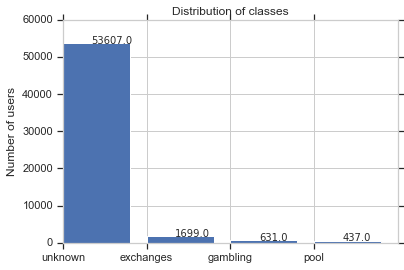

In [64]:
from ml import *
class_hist(adr_df)

In [65]:
x1 = adr_df.loc[adr_df['category']=='unknown']
x2 = adr_df.loc[adr_df['category']=='exchanges']

In [67]:
# balance the dataset: 
indices = np.arange(x1.shape[0])
random_indices = np.random.choice(indices, size = x2.shape[0])
x1 = x1.iloc[random_indices] # choose random staying customers
X = pd.concat((x1, x2))
Y = np.concatenate((np.zeros(x1.shape[0]), np.ones(x2.shape[0])))

In [68]:
from sklearn.model_selection import train_test_split
X = X.drop(columns = ["category"])
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [69]:
dec_tree_classifier, y_pred = get_best_dec_tree(X_train=X_train, y_train=y_train,
                                       X_test=X_test, y_test=y_test)

the accuracy = 0.7658823529411765


In [72]:
scores(y_test,y_pred)

Accuracy: 0.7058823529411765
Recall: [0.59602649 0.83123426]
Precision: [0.80118694 0.64327485]
f1 score: [0.6835443  0.72527473]


saving confusion matrix for decision tree...
confusion matrix normalized: 


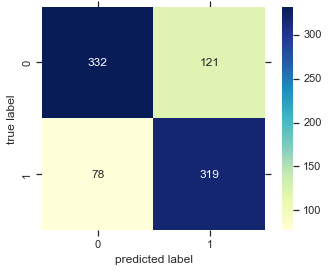

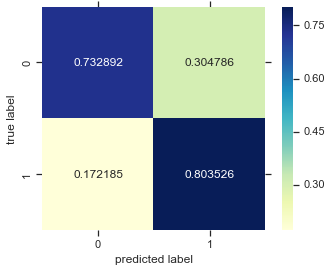

In [70]:
print("saving confusion matrix for decision tree...")
plot_confusion_matrix(y_test, y_pred, "decision_tree_downsampled_conf_matrix")

In [71]:
print("save decision tree with few depth layers for visualization: ")
dec_tree = tree.DecisionTreeClassifier(max_depth = 4, random_state=42)
dec_tree = dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test)
print(accuracy_score(y_test, y_pred))

save decision tree with few depth layers for visualization: 
0.7058823529411765


In [42]:
plot_dec_tree(dec_tree, feature_names=X_train.columns, filename="Decision Tree")

## Unsupervised

In [46]:
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
import imblearn

from sklearn import preprocessing
from sklearn import cluster
import scipy as sp
from sklearn.metrics import silhouette_score

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [47]:
#Normalize data
Y = pd.DataFrame(adr_df['category'])
adr_df_x = adr_df.drop(['category'], axis=1)
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
scaled_x = scaler.fit_transform(adr_df_x)

X = pd.DataFrame(scaled_x, columns=adr_df_x.columns, index=adr_df_x.index)

Explained variation per principal component: [2.43816551e-01 1.75381408e-01 1.65345723e-01 1.22834948e-01
 8.31526847e-02 6.84282854e-02 6.41477224e-02 3.02516366e-02
 2.20067216e-02 1.39821680e-02 3.98299644e-03 3.58844942e-03
 2.95546944e-03 1.25236595e-04]


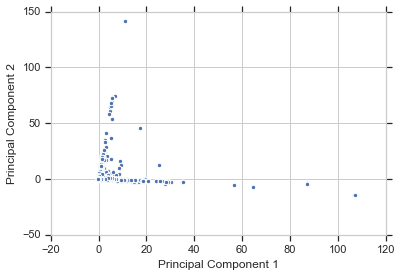

In [51]:
#Principal Component Analysis - DIMENSIONALITY REDUCTION
pca = sklearn.decomposition.PCA()
plot_columns = pca.fit_transform(X)   
#cmap = matplotlib.colors.ListedColormap(colors),
plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


In [52]:
clusters = range(2,10)
meandist=[]
inertias = []
ss = []

for k in clusters:
    model = cluster.KMeans(n_clusters = k)
    model.fit(X)
    meandist.append(sum(np.min(sp.spatial.distance.cdist(X,model.cluster_centers_,'euclidean'),axis=1))/X.shape[0])
    #distorsions.append(model.inertia_) 
    ss.append(silhouette_score(X, model.labels_))

plt.plot(clusters, meandist, '-o')
plt.title('Selecting k with the Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')

# plt.subplot(1, 2, 2)
# plt.plot(clusters, distorsions, '-o')
# plt.title('Selecting k with the Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Model inertia')

plt.show
plt.grid(True)

MemoryError: 

In [ ]:
def pca_and_plot(X_train, y_train):
    pca = sklearn.decomposition.PCA(n_components=2)
    principalComponents = pca.fit_transform(X_train)
    y_df = pd.DataFrame(data = y_train, columns=["category"])
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, y_df], axis=1)
    # 2d plot: 
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA')
    targets = [0,1,2,3]
    colors = ['gray', '#127161', 'red','black']
    markers = ['^','^','^','^']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['category'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , marker=markers[target]
                   , s = 200)
    ax.legend(targets)
    ax.grid()

In [ ]:
X[_Y == 0].shape

In [ ]:
X_balanced = []
y_balanced = []

for i in range(4):
    X_c_sample = X[_Y == i].values
    random_indices = np.random.choice(np.arange(X_c_sample.shape[0]), size=71)
    X_balanced.append(X_c_sample[random_indices])
    y_balanced.append(np.ones(71)*i)

In [ ]:
X_balanced = np.array(X_balanced)
y_balanced = np.array(y_balanced)

In [ ]:
X_balanced = X_balanced.reshape((X_balanced.shape[0]*X_balanced.shape[1], X_balanced.shape[2]))
y_balanced = y_balanced.reshape((y_balanced.shape[0]*y_balanced.shape[1]))

In [ ]:
from sklearn.preprocessing import LabelEncoder 
_Y = LabelEncoder().fit_transform(Y.category)
pca_and_plot(X_balanced, y_balanced)

In [ ]:
def tsne_and_plot(X_train, y_train):
    pca = sklearn.manifold.TSNE()
    principalComponents = pca.fit_transform(X_train, y_train)
    y_df = pd.DataFrame(data = y_train, columns=["category"])
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, y_df], axis=1)
    # 2d plot: 
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA')
    targets = [0,1,2,3]
    colors = ['gray', '#127161', 'red','black']
    markers = ['^','^','^','^']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['category'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , marker=markers[target]
                   , s = 200)
    ax.legend(targets)
    ax.grid()

In [ ]:
tsne_and_plot(X_train=X_balanced, y_train=y_balanced)